# SpikeInterface Tutorial -  SI version > 0.90 - August 2021


In this tutorial, we will cover the basics of using SpikeInterface for extracellular analysis and spike sorting comparison. 
We will be using the `spikeinterface` version>0.90 and highlight API changes from the previous versions (<=0.12). 

For this analysis, we will use a 64-channel dataset from am "ASSY-156-P1" probe from Cambridge Neurotech. The dataset is provided by Samuel McKenzie's Lab. 

We recommend creating a new `spiketutorial` conda environment using:

`conda env create -f environment.yml`


Alternatively, you can install the requirements you can use the `requirements.txt` in this directory by running the command:

`pip install -r requirements.txt`

In [1]:
# Code is credited to Dr. Buccino, and you can find the publication at: https://elifesciences.org/articles/61834

# Full video of the NWB workshop here (uses previous version): https://www.youtube.com/watch?v=fvKG_-xQ4D8

# And the code for SpikeInterface at: https://github.com/SpikeInterface

# My edits are mostly as comments in code cells, and left Dr. Buccino's comments as Markdown.

# Cite their work when applicable/possible! 

In [2]:
# Prior to running this notebook, you will need to clone the repo, and can set up a new environment 
# (as it states above)

# Make sure you are up to date with Xcode if running on MacOs (and up to date in general)

# I had a few other versions of SpikeInterface (SI) on my system and while I don't think they should interfere 
# I ended up removing them all in order to install 0.90. (was getting module errors before doing this)

# The install workflow I ended up using was running the following from terminal: 

# pip install spikeinterface==0.90

# git clone https://github.com/SpikeInterface/spikeinterface.git

# cd spikeinterface

# pip install -r requirements.txt

# jupyter notebook ##gives access to their other branches of tutorials in .py formats - close and go back to terminal

# git clone https://github.com/SpikeInterface/spiketutorials.git #I cloned this from inside the SI directory 

# cd spiketutorials

# cd official_Tutorial_SI_0.90_Aug2021

# pip install -r requirements.txt ## I used the .txt install because I kept having issues with the environment.

# jupyter notebook ## now we can open up the jup notebook and access the tutorial 


# this method may have doubled a few things up, but hey, it worked for me, and that's what's important here.
# and you can copy my annoted version of this notebook into the Tutorial_SI_0.90_Aug2021 folder 

# Table of contents

* [0. Preparation](#preparation)
* [1. Loading the data and probe information](#loading)
* [2. Preprocessing](#preprocessing)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Spike sorting](#spike-sorting)
* [5. Extracting waveforms](#waveforms)
* [6. Postprocessing](#postprocessing)
* [7. Validation and curation](#curation)
* [8. Spike sorting comparison](#comparison)
* [9. Exporters](#exporters)

# 0. Preparation <a class="anchor" id="preparation"></a>

### Download the ephys data

First, we need to download the recording. Feel free to use your own recordings as well later on. 
From this Zenodo [link](https://doi.org/10.5281/zenodo.4657314), you can download the dataset mentioned above (`cambridge_data.bin`). Move the dataset in the current folder and unzip it.
The recording was performed with the "ASSY-156-P1" probe with 4 shanks of 16 channels (in total 64 channels).


### Import the modules

Let's now import the `spikeinterface` modules that we need:

In [3]:
# We import our packages. If you were following other tutorials or online info, these packages 
# can be imported differently, so don't get tripped up. 

import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

# 1. Loading recording and probe information <a class="anchor" id="loading"></a>

In [5]:
# depending on how you completed the install, where this notebook resides, and where the cambridge_data is, 
# will alter the path to the .bin file 

# bin files are binary non-text files, and is the format this practice data comes in. 
# You can check out some of their other .py programs that show you how to generate simulated data 
# or, as you noticed from Zenodo, there are a few other datasets they've provided

In [6]:
# file path
recording_file = '/Users/mac/Downloads/cambridge_data.bin' # This will your path not mine ;) 

# parameters to load the bin/dat format
num_channels = 64
sampling_frequency = 20000
gain_to_uV = 0.195
offset_to_uV = 0
dtype="int16"
time_axis = 1

In [7]:
recording = si.read_binary(recording_file, num_chan=num_channels, sampling_frequency=sampling_frequency,
                           dtype=dtype, gain_to_uV=gain_to_uV, offset_to_uV=offset_to_uV, 
                           time_axis=time_axis)

In [8]:
# Here's how they read in the other dataset from last year: 

#recording_folder = 'open-ephys-dataset/'
#recording = se.OpenEphysRecordingExtractor(recording_folder)

The `read_binary()` function returns a `RecordingExtractor` object. We can print it to visualize some of its properties:

In [9]:
print(recording)

BinaryRecordingExtractor: 64 channels - 1 segments - 20.0kHz - 600.000s
  file_paths: ['/Users/mac/Downloads/cambridge_data.bin']


We can further `annotate` the recording to tell SI that it is not filtered yet. This will prevent further mistakes in the pipieline, such as attempting to extract waveforms from unfiltered data.

In [10]:
recording.annotate(is_filtered=False)

While the `read_binary()` function is part of the `core` module (as it's used internally by SI to store data in a convenient format), the `extractor` module allows you to load many file formats used in electrophysiology. 

The extractors available in SI are all loaded using the [NEO](https://neo.readthedocs.io/en/stable/) python package.

We can access the full list of available extractors with:

In [11]:
# Take a look at the full list and see what is best for the data
se.recording_extractor_full_list

[spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor,
 spikeinterface.core.numpyextractors.NumpyRecording,
 spikeinterface.extractors.shybridextractors.SHYBRIDRecordingExtractor,
 spikeinterface.extractors.mdaextractors.MdaRecordingExtractor,
 spikeinterface.extractors.neoextractors.mearec.MEArecRecordingExtractor,
 spikeinterface.extractors.neoextractors.spikeglx.SpikeGLXRecordingExtractor,
 spikeinterface.extractors.neoextractors.openephys.OpenEphysLegacyRecordingExtractor,
 spikeinterface.extractors.neoextractors.openephys.OpenEphysBinaryRecordingExtractor,
 spikeinterface.extractors.neoextractors.intan.IntanRecordingExtractor,
 spikeinterface.extractors.neoextractors.neuroscope.NeuroScopeRecordingExtractor,
 spikeinterface.extractors.neoextractors.plexon.PlexonRecordingExtractor,
 spikeinterface.extractors.neoextractors.neuralynx.NeuralynxRecordingExtractor,
 spikeinterface.extractors.neoextractors.blackrock.BlackrockRecordingExtractor,
 spikeinterface.extractors.

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The `BinaryRecordingExtractor` is designed specifically for raw binary files datasets (.bin, .dat, .raw).

Here we load information from the recording using the built-in functions from the RecordingExtractor

In [12]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_segments = recording.get_num_segments()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")

Channel ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Sampling frequency: 20000
Number of channels: 64
Number of segments: 1


**NEW:** The new SI version supports multi-segment recordings. A segment is a contiguous piece of data, and sometimes recordings can be made of multiple acquisitions, for examples a baseline, a stimulation phase, and a post recording. In such cases, the recording object will be made of multiple segments and be treated as such over the pipeline.

The `get_traces()` function returns a TxN numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [13]:
# So if you want to take two seconds of recording data, you take the sampling freq (fs) which occurs over one second 
# and multiply by 2 (shown as end frame = int(x) )
trace_snippet = recording.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [14]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (40000, 64)


The `widgets` module includes several convenient plotting functions that can be used to explore the data:

In [15]:
# you can check out the widgets gallery here: 
# https://github.com/SpikeInterface/spikeinterface/tree/master/examples/modules/widgets
# which contains some plotting examples as .py programs

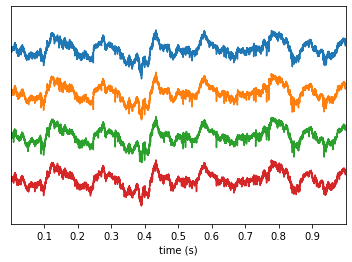

In [16]:
w_ts = sw.plot_timeseries(recording, channel_ids=[0, 1, 2, 3])

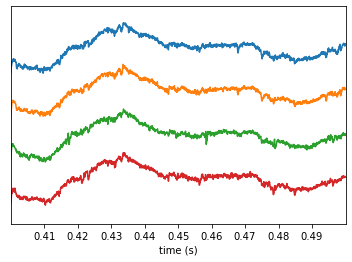

In [17]:
# If we want to plot a small amount of time during the recording we add in the trange parameter
w_ts = sw.plot_timeseries(recording, channel_ids=[0, 1, 2, 3], time_range=[0.4,0.5])

In [18]:
# As always, if you want to know what other arguments can be used with spikeinterface functions: 
sw.plot_timeseries?

Before moving on with the analysis, we have to load the probe information. For this we will use the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html) package. 

ProbeInterface allows to easily create, manipulate, and visualize neural probes. Moreover, it comes with a wide range of IO functions to import and export existing formats. Finally, we have created a public library of commercial probes (https://gin.g-node.org/spikeinterface/probeinterface_library/) that can be retrieved with a single line of code.

Let's import `probeinterface`, download the probe and plot it!

In [19]:
import probeinterface as pi
from probeinterface import plotting

In [20]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-156-P-1'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

cambridgeneurotech - ASSY-156-P-1 - 64ch


In most experiments, the neural probe has a connector, that is interfaced to an headstage, which in turn connects to the acquisition system. This *pathway* usually results in a channel remapping, which means that the order of the contacts on the probe is different than the order of the recorded traces.

`probeinterface` provides a growing collection of common pathways that can be loaded directly to wire a device and apply the correct channel mapping:

In [ ]:
# https://open-ephys.org/mousecam

In [ ]:
# In simple terms, when they say probe, they are referrring to their electrode set-up they used for recording 
# in this case, they are using one from cambridgeneurotech, which looks like: 
# https://www.cambridgeneurotech.com/assets/files/ASSY-156-P-1-P-2-map.pdf

# Having the probe interface saves us a lot of hard coding for assigning contacts/shanks/channels.

In [21]:
pi.get_available_pathways()

['H32>RHD2132', 'ASSY-156>RHD2164', 'ASSY-77>Adpt.A64-Om32_2x-sm>RHD2164']

In [22]:
probe.wiring_to_device('ASSY-156>RHD2164')

(<matplotlib.collections.PolyCollection at 0x7fc15f69e430>,
 <matplotlib.collections.PolyCollection at 0x7fc15f30abb0>)

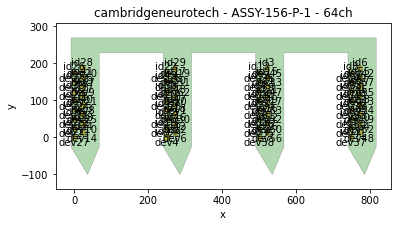

In [23]:
plotting.plot_probe(probe, with_contact_id=True, with_device_index=True)

The probe now has contact ids `id#` and device ids `dev#`! We can also visualize the probe information as a `pandas` dataframe:

In [24]:
probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,1,2,47
1,2,2,46
2,3,2,45
3,4,2,44
4,5,3,43
...,...,...,...
59,60,3,52
60,61,3,51
61,62,3,50
62,63,3,49


In [25]:
# saving to a pandas dataframe:
probe_frame = probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]
print(probe_frame.groupby('shank_ids').groups.keys())
print(probe_frame.groupby('device_channel_indices').groups.keys())

# How great is pandas dataframe manipulation!

dict_keys(['0', '1', '2', '3'])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])


Note that also the `shank_id` is loaded with the probe.

**NEW:** A `probeinterface` object can be loaded directly to a SI recording object:

In [26]:
recording_prb = recording.set_probe(probe, group_mode="by_shank")

When loading the probe, the device indices (and all the other contact properties) are automatically sorted:

In [27]:
probe_rec = recording_prb.get_probe()
probe_rec.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

,contact_ids,shank_ids,device_channel_indices
0,48,1,0
1,47,1,1
2,46,1,2
3,45,1,3
4,44,1,4
...,...,...,...
59,53,2,59
60,52,2,60
61,51,2,61
62,50,1,62


In [28]:
print(f'Channels after loading the probe file: {recording_prb.get_channel_ids()}')
print(f'Channel groups after loading the probe file: {recording_prb.get_channel_groups()}')

Channels after loading the probe file: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Channel groups after loading the probe file: [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 2 1 1 0 0 0 0 0 0 1 0 1 1 1 1 2 2 2 2 2
 3 3 3 3 3 3 3 2 2 2 2 3 3 3 3 3 3 3 3 2 3 2 2 2 2 1 2]


### Properties 

`RecordingExtractor` object can have *properties*. A property is a piece of information attached to a channel, e.g. group or location.

Similarly, for `SortingExtractor` objects (that we'll cover later), anything related to a unit can be stored as a property. 

We can check which properties are in the extractor as follows:

In [ ]:
# We'll mostly skip over this section for the sake of time 
# but the important thing to note is that properties can can be added such as the brain region by channel

# Features are aspects such as waveforms or spike amplitudes 
# Properties are those not belonging to a single spike

In [29]:
print("Properties before loading the probe:", list(recording.get_property_keys()))

Properties before loading the probe: ['gain_to_uV', 'offset_to_uV']


In [30]:
print("Properties after loading the probe:", list(recording_prb.get_property_keys()))

Properties after loading the probe: ['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group']


After loading the probe we now have some new properties: `contact_vector`, `location`, and `group`.

Let's add some new properties! 
The first 32 channels are in the CA1 area, the second 32 are in the CA3 area:

In [31]:
brain_area_property_values = ['CA1']*32 + ['CA3']*32
print(brain_area_property_values)

['CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3']


In [32]:
recording_prb.set_property(key='brain_area', values=brain_area_property_values)

We can also specify a property on a subset of channels. In this case, the non-specified channels will be filled empty values:

**NOTE:** Internally the properties is jus a dictionary attached to the recording that is accessible as `_properties`

In [33]:
print(recording_prb._properties.keys())

dict_keys(['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'brain_area'])


### Annotations

*Annotations* can be attached to any object and they can carry any information related to the recording or sorting objects.

Let's add an annotation about this tutorial:

In [34]:
recording_prb.annotate(description="Dataset for SI 0.90 tutorial")

In [35]:
print(recording_prb.get_annotation_keys())

['is_filtered', 'probe_0_planar_contour', 'description']


# 2. Preprocessing <a class="anchor" id="preprocessing"></a>


Now that the probe information is loaded we can do some preprocessing using `toolkit` module.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

We will focus only on the first shank (grouo `0`) for the following analysis:

In [36]:
recordings_by_group = recording_prb.split_by("group")
print(recordings_by_group)

{0: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 1: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 2: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 3: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s}


In [37]:
recording_to_process = recordings_by_group[0]

Below, we bandpass filter the recording and apply common median reference to the original recording:

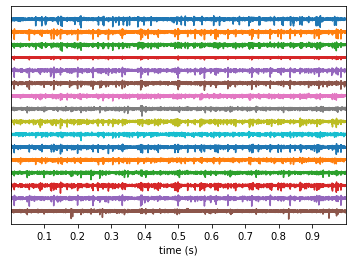

In [38]:
# bandpass_filters pass frequencies within a certain range

recording_f = st.bandpass_filter(recording_to_process, freq_min=300, freq_max=6000)

w = sw.plot_timeseries(recording_f)

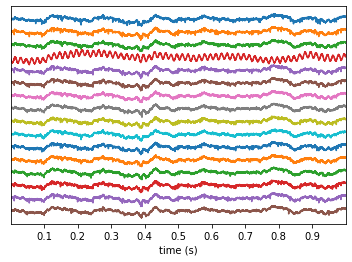

In [39]:
# compared to our unfiltered signal!! 
w_unfiltered = sw.plot_timeseries(recording_to_process)

We can see that the after filtering we can observe spiking activity on many channels! We can also apply other preprocessing steps to further increase the quality of the recording. 

For examplem let's apply Common Median Reference (CMR)

In [40]:
# At each time step, removes median of all channels, which removes common noise and cleans the recording
recording_cmr = st.common_reference(recording_f, reference='global', operator='median')

We can plot the traces after applying CMR:

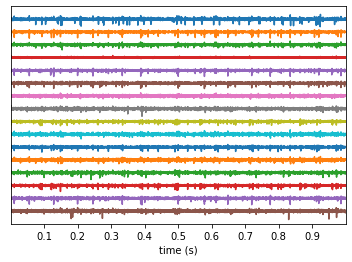

In [41]:
w = sw.plot_timeseries(recording_cmr)

Since we are going to spike sort the data, let's first cut out a 5-minute recording, to speed up computations.

We can easily do so with the `frame_slice()` function:

In [42]:
fs = recording_cmr.get_sampling_frequency()
recording_sub = recording_cmr.frame_slice(start_frame=0*fs, end_frame=300*fs)

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 

In [43]:
recording_saved = recording_sub.save(folder="preprocessed4", progress_bar=True, 
                                     n_jobs=4, total_memory="100M")

write_binary_recording with n_jobs 4  chunk_size 781250


write_binary_recording: 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


If we inspect the `preprocessed` folder, we find that a few files have been saved. Let's take a look at what they are:

In [44]:
# taking a look, looks like things saved correctly 
!ls preprocessed/

cached.json            properties             traces_cached_seg0.raw
probe.json             provenance.json


The `traces_cached_seg0.raw` contains the processed raw data, while the `.json` files include information on how to reload the binary file. The `provenance.json` includes the information of the recording before saving it to a binary file, and the `probe.json` represents the probe object. 

The `save` returns a new *cached* recording that has all the previously loaded information:

In [45]:
print(f'Cached channels ids: {recording_saved.get_channel_ids()}')
print(f'Channel groups after caching: {recording_saved.get_channel_groups()}')

Cached channels ids: [ 7  8  9 10 11 12 13 14 15 20 21 22 23 24 25 27]
Channel groups after caching: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


After saving the SI object, we can easily load it back in a new session:

In [46]:
recording_loaded = si.load_extractor("preprocessed/")

In [47]:
print(f'Loaded channels ids: {recording_loaded.get_channel_ids()}')
print(f'Channel groups after loading: {recording_loaded.get_channel_groups()}')

Loaded channels ids: [ 7  8  9 10 11 12 13 14 15 20 21 22 23 24 25 27]
Channel groups after loading: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


We can double check that the traces are exactly the same as the `recording_saved` that we saved:

Text(0.5, 1.0, 'Loaded')

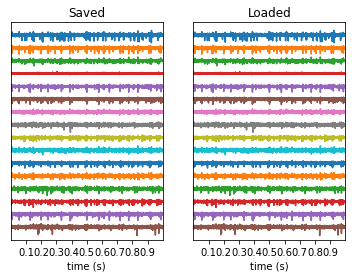

In [48]:
fig, axs = plt.subplots(ncols=2)
w_saved = sw.plot_timeseries(recording_saved, ax=axs[0])
w_loaded = sw.plot_timeseries(recording_loaded, ax=axs[1])
axs[0].set_title("Saved")
axs[1].set_title("Loaded")

**IMPORTANT**: the same saving mechanisms are available also for all SortingExtractor

# 4. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording. We will use `herdingspikes` and `ironclust` for this demonstration, to show how easy SpikeInterface makes it easy to interchengably run different sorters :)

Let's first check the installed sorters in spiketoolkit to see if herdingspikes is available. Then we can then check the `herdingspikes` default parameters.
We will sort the bandpass cached filtered recording the `recoridng_saved` object.

In [49]:
ss.installed_sorters()

['herdingspikes']

In [ ]:
# How did we get herdingspikes? it's in the list of requirements.txt !!! 

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `sorters` module:

In [50]:
ss.get_default_params('herdingspikes')

{'clustering_bandwidth': 5.5,
 'clustering_alpha': 5.5,
 'clustering_n_jobs': -1,
 'clustering_bin_seeding': True,
 'clustering_min_bin_freq': 16,
 'clustering_subset': None,
 'left_cutout_time': 0.3,
 'right_cutout_time': 1.8,
 'detect_threshold': 20,
 'probe_masked_channels': [],
 'probe_inner_radius': 70,
 'probe_neighbor_radius': 90,
 'probe_event_length': 0.26,
 'probe_peak_jitter': 0.2,
 't_inc': 100000,
 'num_com_centers': 1,
 'maa': 12,
 'ahpthr': 11,
 'out_file_name': 'HS2_detected',
 'decay_filtering': False,
 'save_all': False,
 'amp_evaluation_time': 0.4,
 'spk_evaluation_time': 1.0,
 'pca_ncomponents': 2,
 'pca_whiten': True,
 'freq_min': 300.0,
 'freq_max': 6000.0,
 'filter': True,
 'pre_scale': True,
 'pre_scale_value': 20.0,
 'filter_duplicates': True}

In [ ]:
ss.run_sorter?

In [ ]:
ss.run_herdingspikes?

To modify a parameter, we can easily pass it to the `run` function as an extra argument!
For example, let's set the `filter` parameter to False as the recording is already preprocessed:

In [51]:
# run spike sorting on entire recording
sorting_HS = ss.run_herdingspikes(recording_saved, output_folder='results_HS', 
                                  filter=False, verbose=True)
print('Found', len(sorting_HS.get_unit_ids()), 'units')

Herdingspikes use the OLD spikeextractors with RecordingExtractorOldAPI
# Generating new position and neighbor files from data file
# Not Masking any Channels
# Sampling rate: 20000
# Localization On
# Number of recorded channels: 16
# Analysing frames: 6000000; Seconds: 300.0
# Frames before spike in cutout: 6
# Frames after spike in cutout: 36
# tcuts: 26 56
# tInc: 100000
# Analysing frames from -26 to 100056  (0.0%)
# Analysing frames from 99974 to 200056  (1.7%)
# Analysing frames from 199974 to 300056  (3.3%)
# Analysing frames from 299974 to 400056  (5.0%)
# Analysing frames from 399974 to 500056  (6.7%)
# Analysing frames from 499974 to 600056  (8.3%)
# Analysing frames from 599974 to 700056  (10.0%)
# Analysing frames from 699974 to 800056  (11.7%)
# Analysing frames from 799974 to 900056  (13.3%)
# Analysing frames from 899974 to 1000056  (15.0%)
# Analysing frames from 999974 to 1100056  (16.7%)
# Analysing frames from 1099974 to 1200056  (18.3%)
# Analysing frames from 1199

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Number of estimated units: 19
Saving to results_HS/HS2_sorted.hdf5
herdingspikes run time 9.00s
Found 19 units


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.8s finished


SpikeInterface ensures full provenance of the spike sorting pipeline. Upon running a spike sorter, a `spikeinterface_params.json` file is saved in the `output_folder`. This contains a `.json` version of the recording and all the input parameters. 

In [52]:
!ls results_hs/

HS2_detected.bin
HS2_detectedDetectionDict2021-09-09_132731_641021.txt
HS2_sorted.hdf5
spikeinterface_log.json
spikeinterface_params.json
spikeinterface_recording.json


### Installing IronClust (requires MATLAB)

For MATLAB-based sorters, all you need to do is cloning the sorter repo and point it to SpikeInterface:

Let's clone ironclust in the current directory:

In [ ]:
!git clone https://github.com/flatironinstitute/ironclust

The spike sorting returns a `SortingExtractor` object. Let's see some of its functions:

We can use `spikewidgets` functions for some quick visualizations:

In [ ]:
# again we can look back to widgets gallery for these functions

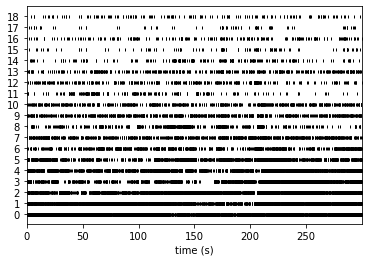

In [53]:
w_rs = sw.plot_rasters(sorting_HS)

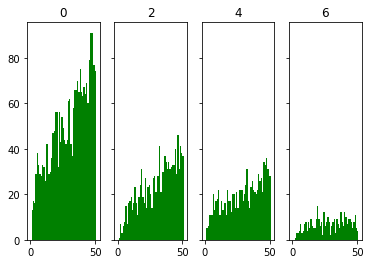

In [54]:
w_ach = sw.plot_autocorrelograms(sorting_HS, unit_ids=[0, 2, 4, 6])

# Running multiple sorter jobs in parallel

So far we have seen how to run one sorter at a time. SI provides a convenient launcher in order to run multiple sorters on multiple recordings with one line of code!

The `run_sorters()` function of the `sorter` module allows you to specify a list of sorters to use on a list (or dictionary) of parameters. The jobs are by default ran in a loop, but the `engine` argument enables to specify a parallel backend (`joblib` or `dask`) and relative parameters.

In the following example, we run the 2 jobs to run `herdingspikes` and `ironclust` in parallel:

In [ ]:
sorting_outputs = ss.run_sorters(sorter_list=["herdingspikes", "ironclust"],
                                 recording_dict_or_list={"group0": recording_saved},
                                 working_folder="all_sorters",
                                 verbose=False,
                                 engine="joblib",
                                 engine_kwargs={'n_jobs': 2})

## Spike sort in Docker containers
###  (Linux and MacOS only)

Some sorters are hard to install! To alleviate this headache, SI provides a built-in mechanism to run a spike sorting job in a docker container.

We are maintaining a set of sorter-specific docker files in the [spikeinterface-dockerfiles repo](<https://github.com/SpikeInterface/spikeinterface-dockerfiles>)
and most of the docker images are available on Docker Hub from the [SpikeInterface organization](<https://hub.docker.com/orgs/spikeinterface/repositories>).

Running spike sorting in a docker container just requires to:

1. have docker installed
2. have docker python SDK installed (`pip install docker`)

When docker is installed, you can simply run the sorter in a specified docker image:

# 5. Extracting waveforms <a class="anchor" id="waveforms"></a>

The core of postprocessing spike sorting results revolves around extracting waveforms from paired recording-sorting objects.

**NEW** In the SI API, waveforms are extracted using the `WaveformExtractor` class in the `core` module.

The `WaveformExtractor` object has convenient functions to retrieve waveforms and templates.
Let's see how it works.

To extract the waveforms, we can run:

In [ ]:
si.extract_waveforms?

In [55]:
we = si.extract_waveforms(recording_saved, sorting_HS, folder="wf_HS", progress_bar=True,
                          n_jobs=1, total_memory="500M", overwrite=True)
print(we)

extract waveforms: 100%|##########| 1/1 [00:00<00:00,  1.23it/s]

WaveformExtractor: 16 channels - 19 units - 1 segments
  before:60 after80 n_per_units: 500


Now all waveforms are computed and stored in the provided `wf_HS` folder. We can now retrieve waveforms and templates easily:

In [56]:
waveforms0 = we.get_waveforms(unit_id=0)
print(f"Waveforms shape: {waveforms0.shape}")
template0 = we.get_template(unit_id=0)
print(f"Template shape: {template0.shape}")
all_templates = we.get_all_templates()
print(f"All templates shape: {all_templates.shape}")

Waveforms shape: (500, 140, 16)
Template shape: (140, 16)
All templates shape: (19, 140, 16)


For waveforms, the dimension is (num_spikes, num_samples, num_channels), while each template has dimension (num_samples, num_channels). Note that the number of spikes in this case is 500..we'll get back to it later!

The `WaveformExtractor` is also compatible with several `widgets` to visualize the spike sorting output:

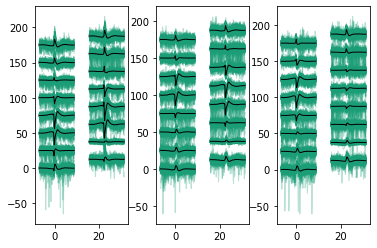

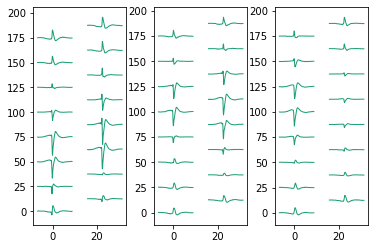

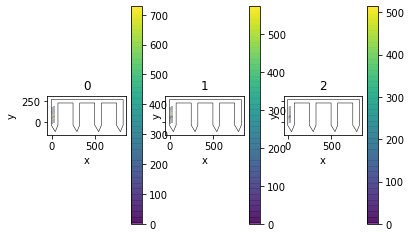

In [57]:
w = sw.plot_unit_waveforms(we, unit_ids=[0,1,2])
w = sw.plot_unit_templates(we, unit_ids=[0,1,2])
w = sw.plot_unit_probe_map(we, unit_ids=[0,1,2])

In [ ]:
w = sw.plot_unit_summary(we, unit_id=1)

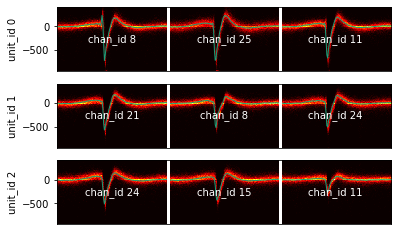

In [58]:
unit_ids = sorting_HS.unit_ids[:3]
sw.plot_unit_waveform_density_map(we, unit_ids=unit_ids, max_channels=3)

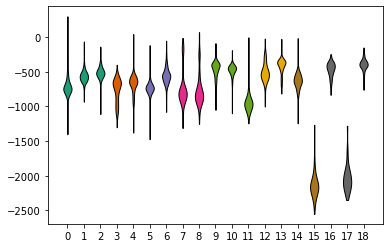

In [59]:
sw.plot_amplitudes_distribution(we)

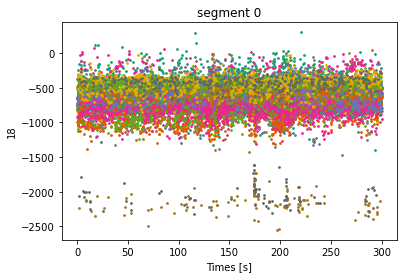

In [60]:
sw.plot_amplitudes_timeseries(we)

As we noticed before, the number of spikes for the waveforms is 500. Let's check the number of spikes for other waveforms:

In [61]:
for unit in sorting_HS.get_unit_ids():
    waveforms = we.get_waveforms(unit_id=unit)
    spiketrain = sorting_HS.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Unit 0 - num waveforms: 500 - num spikes: 4352
Unit 1 - num waveforms: 500 - num spikes: 3164
Unit 2 - num waveforms: 500 - num spikes: 3060
Unit 3 - num waveforms: 500 - num spikes: 2067
Unit 4 - num waveforms: 500 - num spikes: 2426
Unit 5 - num waveforms: 500 - num spikes: 1717
Unit 6 - num waveforms: 500 - num spikes: 921
Unit 7 - num waveforms: 500 - num spikes: 822
Unit 8 - num waveforms: 500 - num spikes: 652
Unit 9 - num waveforms: 500 - num spikes: 679
Unit 10 - num waveforms: 500 - num spikes: 530
Unit 11 - num waveforms: 258 - num spikes: 258
Unit 12 - num waveforms: 344 - num spikes: 344
Unit 13 - num waveforms: 413 - num spikes: 413
Unit 14 - num waveforms: 240 - num spikes: 240
Unit 15 - num waveforms: 123 - num spikes: 123
Unit 16 - num waveforms: 211 - num spikes: 211
Unit 17 - num waveforms: 86 - num spikes: 86
Unit 18 - num waveforms: 151 - num spikes: 151


No units have more than 500 spikes! This is because by default, the `WaveformExtractor` extracts waveforms on a random subset of 500 spikes. To extract waveforms on all spikes, we can use the `max_spikes_per_unit` argument:

In [63]:
we_all = si.extract_waveforms(recording_saved, sorting_HS, folder="wf_HS_all2", 
                              max_spikes_per_unit=None, progress_bar=True)

extract waveforms: 100%|##########| 1/1 [00:02<00:00,  2.14s/it]


In [64]:
for unit in sorting_HS.get_unit_ids():
    waveforms = we_all.get_waveforms(unit_id=unit)
    spiketrain = sorting_HS.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Unit 0 - num waveforms: 4352 - num spikes: 4352
Unit 1 - num waveforms: 3164 - num spikes: 3164
Unit 2 - num waveforms: 3060 - num spikes: 3060
Unit 3 - num waveforms: 2067 - num spikes: 2067
Unit 4 - num waveforms: 2426 - num spikes: 2426
Unit 5 - num waveforms: 1717 - num spikes: 1717
Unit 6 - num waveforms: 921 - num spikes: 921
Unit 7 - num waveforms: 822 - num spikes: 822
Unit 8 - num waveforms: 652 - num spikes: 652
Unit 9 - num waveforms: 679 - num spikes: 679
Unit 10 - num waveforms: 530 - num spikes: 530
Unit 11 - num waveforms: 258 - num spikes: 258
Unit 12 - num waveforms: 344 - num spikes: 344
Unit 13 - num waveforms: 413 - num spikes: 413
Unit 14 - num waveforms: 240 - num spikes: 240
Unit 15 - num waveforms: 123 - num spikes: 123
Unit 16 - num waveforms: 211 - num spikes: 211
Unit 17 - num waveforms: 86 - num spikes: 86
Unit 18 - num waveforms: 151 - num spikes: 151


Now waveforms have been extracted for all spikes! Let's move on to explore the postprocessing capabilities of the `toolkit` module.

# 6. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analisys (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `toolkit` module.

### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [65]:
pc = st.compute_principal_components(we, n_components=3)

In [66]:
pc0 = pc.get_components(unit_id=0)
print(f"PC scores shape: {pc0.shape}")
all_labels, all_pcs = pc.get_all_components()
print(f"All PC scores shape: {all_pcs.shape}")

PC scores shape: (500, 3, 16)
All PC scores shape: (7326, 3, 16)


For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). 
The `get_all_components()` function returns an array with the label/unit id for each component (`all_labels`) and an array of dimension (num_all_samples, num_components, num_channels). 

### Spike amplitudes

Spike amplitudes can be computed with the `get_spike_amplitudes` function.

In [67]:
amplitudes = st.get_spike_amplitudes(we, outputs="concatenated", progress_bar=True)

extract amplitudes: 100%|##########| 1/1 [00:00<00:00, 12.79it/s]


By default, all amplitudes are concatenated in one array.

The correspinding spike times and labels can be easily retrieved as:

In [68]:
all_spike_times, all_spike_labels = sorting_HS.get_all_spike_trains()[0]

The [0] index is to select the first segment. In case of multiple segments each element will correspond to a different segment and will contain spike times and labels for that segment.


### Compute template metrics

Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `toolkit` allows one to compute several of these metrics:

In [69]:
print(st.get_template_metric_names())

['peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope']


In [70]:
template_metrics = st.calculate_template_metrics(we)
display(template_metrics)

,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope
0,0.0006,-0.249233,None,1971424.077352,-242186.248109
1,0.00065,-0.314312,0.0003,1498470.525287,-238198.333321
2,0.00065,-0.289132,0.0003,1373749.347868,-188165.167169
3,0.0006,-0.3075,0.0003,2163718.292648,-321072.185307
4,0.0006,-0.273521,0.0003,2132356.049674,-237899.787651
5,0.0006,-0.289102,0.0003,2101089.590391,-269259.285392
6,0.00065,-0.278899,0.00025,1867942.22423,-239357.964903
7,0.0002,-0.157795,0.0002,6410526.428223,-152755.498865
8,0.00065,-0.218202,0.0002,2269426.146689,-245952.885722
9,0.00065,-0.290216,0.0003,1150424.743834,-160092.03565


In [71]:
from spikeinterface.sortingcomponents import detect_peaks

peaks = detect_peaks(
        recording_f, method='locally_exclusive', 
        peak_sign='neg', detect_threshold=6, n_shifts=7,
        local_radius_um=100,
        noise_levels=None,
        random_chunk_kwargs={},
        chunk_memory='10M', n_jobs=1, progress_bar=True)

detect peaks:   0%|          | 0/39 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11003. The TBB threading layer is disabled.
  warnings.warn(problem)
detect peaks: 100%|##########| 39/39 [00:14<00:00,  2.76it/s]


In [ ]:
#import spikeinterface as si
#import spikeinterface.extractors as se 
#import spikeinterface.toolkit as st
#import spikeinterface.sorters as ss
#import spikeinterface.comparison as sc
#import spikeinterface.widgets as sw

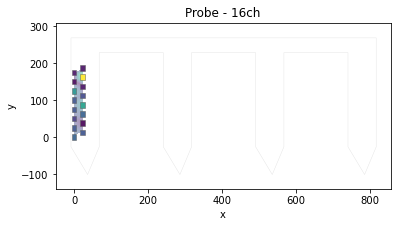

In [72]:
sw.plot_peak_activity_map(recording_f, peaks=peaks)

For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

# 7. Validation and curation <a class="anchor" id="curation"></a>

The `toolkit` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

Let's see what metrics are available:

In [73]:
print(st.get_quality_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff']


In [74]:
qc = st.compute_quality_metrics(we_all, waveform_principal_component=pc)

In [75]:
display(qc)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_rate,isi_violations_count,amplitude_cutoff,isolation_distance,l_ratio,d_prime
0,4352,14.506667,1.00,16.537735,0.020000,6,0.001645,72.742782,0.153663,4.106693
1,3164,10.546667,1.00,12.166139,0.003333,1,0.000082,109.500093,0.004383,5.701296
2,3060,10.200000,1.00,10.405885,0.000000,0,0.000085,92.779460,0.105672,4.036550
3,2067,6.890000,0.94,11.291851,0.003333,1,0.006122,130.217423,0.002369,3.571809
4,2426,8.086667,1.00,11.495437,0.006667,2,0.000107,96.249645,0.039356,3.836551
5,1717,5.723333,0.99,16.867622,0.006667,2,0.000151,76.124526,0.127733,4.232060
6,921,3.070000,0.99,12.835475,0.000000,0,0.000281,77.410630,0.143806,3.527676
7,822,2.740000,1.00,13.927288,0.006667,2,0.133335,102.253262,0.014398,4.275962
8,652,2.173333,0.92,13.475403,0.003333,1,0.088701,67.188782,0.465522,4.012588
9,679,2.263333,1.00,8.674386,0.000000,0,0.019846,59.496006,0.624526,3.171664


For more information about these waveform features, we refer to this [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

In [ ]:
# That's all for now 
# For other curation, and data exporting, refer to the full length notebook or talk